# Setup

---



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import pandas as pd
import numpy as np
import kagglehub

# Dataset

In [ ]:
path = kagglehub.dataset_download("sakshiidewangan/flight-price-dataset")

dataset = pd.read_excel(path + '/Data_Train.xlsx')
dataset

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


# Data Pre-Processing

In [ ]:
dataset = dataset[['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Duration', 'Total_Stops', 'Price']].copy()
dataset

,Airline,Date_of_Journey,Source,Destination,Duration,Total_Stops,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,2h 50m,non-stop,3897
1,Air India,1/05/2019,Kolkata,Banglore,7h 25m,2 stops,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,19h,2 stops,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,5h 25m,1 stop,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,4h 45m,1 stop,13302
...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,2h 30m,non-stop,4107
10679,Air India,27/04/2019,Kolkata,Banglore,2h 35m,non-stop,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,3h,non-stop,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,2h 40m,non-stop,12648


In [ ]:
# Label Encoding
stop_mapping = {
    '4 stops': 4,
    '3 stops': 3,
    '2 stops': 2,
    '1 stop': 1,
    'non-stop': 0
}
dataset['Total_Stops'] = dataset['Total_Stops'].map(stop_mapping)
dataset['Total_Stops'] = dataset['Total_Stops'].fillna(0).astype(int)

# One Hot Encoding
# Duration
def convert_to_minutes(time_str):
    if pd.isna(time_str):  # Handle potential NaN values
        return None
    parts = time_str.replace(' ', '').replace('h', ' ').replace('m', '').split(' ')
    hours = int(parts[0]) if parts[0] else 0
    minutes = int(parts[1]) if len(parts) > 1 and parts[1] else 0
    return hours * 60 + minutes

# Apply the function to the 'Duration_Time' column
dataset['Duration'] = dataset['Duration'].apply(convert_to_minutes)

# AirLine
categorical_columns = dataset[['Airline', 'Source', 'Destination']].columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(dataset[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
dataset = pd.concat([dataset, one_hot_df], axis=1)
dataset = dataset.drop(categorical_columns, axis=1)

# Changing Data Type
dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'], dayfirst=True)
dataset['Date_of_Journey'] = dataset['Date_of_Journey'].apply(lambda x: x.strftime('%Y-%m-%d'))
dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'])

# Separate Date Format
dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey'], dayfirst=True)

dataset['Journey_Day'] = dataset['Date_of_Journey'].dt.day
dataset['Journey_Month'] = dataset['Date_of_Journey'].dt.month
dataset['Journey_Weekday'] = dataset['Date_of_Journey'].dt.dayofweek

dataset = dataset.drop('Date_of_Journey', axis=1)

dataset

,Duration,Total_Stops,Price,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Journey_Day,Journey_Month,Journey_Weekday
0,170,0,3897,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,24,3,6
1,445,2,7662,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,5,2
2,1140,2,13882,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9,6,6
3,325,1,6218,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12,5,6
4,285,1,13302,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,150,0,4107,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9,4,1
10679,155,0,4145,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27,4,5
10680,180,0,7229,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,4,5
10681,160,0,12648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3,4


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Duration                                   10683 non-null  int64  
 1   Total_Stops                                10683 non-null  int64  
 2   Price                                      10683 non-null  int64  
 3   Airline_Air Asia                           10683 non-null  float64
 4   Airline_Air India                          10683 non-null  float64
 5   Airline_GoAir                              10683 non-null  float64
 6   Airline_IndiGo                             10683 non-null  float64
 7   Airline_Jet Airways                        10683 non-null  float64
 8   Airline_Jet Airways Business               10683 non-null  float64
 9   Airline_Multiple carriers                  10683 non-null  float64
 10  Airline_Multiple carri

# EDA

In [ ]:
dataset.describe()

,Duration,Total_Stops,Price,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Journey_Day,Journey_Month,Journey_Weekday
count,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,...,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,643.120846,0.824113,9087.064121,0.029861,0.163999,0.018160,0.192174,0.360292,0.000562,0.111954,...,0.065244,0.268745,0.424693,0.118412,0.065244,0.035664,0.087241,13.508378,4.708602,2.934850
std,507.835322,0.675244,4611.359167,0.170210,0.370292,0.133535,0.394028,0.480108,0.023693,0.315324,...,0.246967,0.443328,0.494320,0.323111,0.246967,0.185460,0.282202,8.479277,1.164357,2.006698
min,75.000000,0.000000,1759.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,170.000000,0.000000,5277.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,1.000000
50%,520.000000,1.000000,8372.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,5.000000,3.000000
75%,930.000000,1.000000,12373.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,21.000000,6.000000,5.000000
max,2860.000000,4.000000,79512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,27.000000,6.000000,6.000000


<Axes: xlabel='Price', ylabel='Count'>

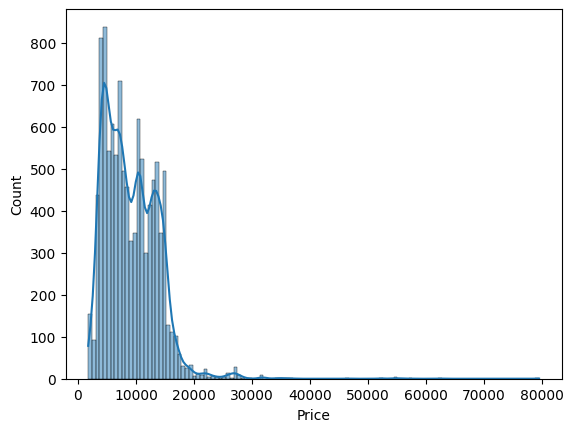

In [ ]:
sns.histplot(dataset['Price'], kde=True)

<Axes: xlabel='Duration', ylabel='Count'>

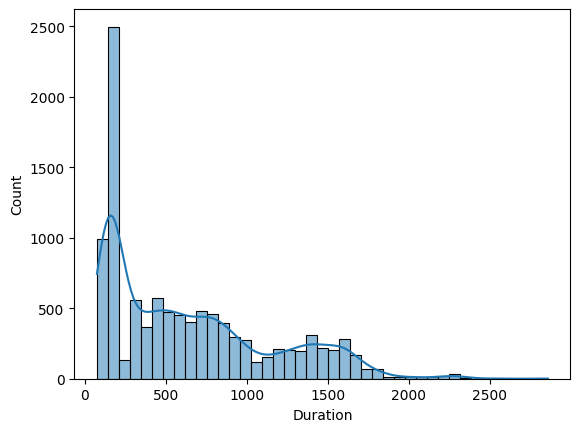

In [ ]:
sns.histplot(dataset['Duration'], kde=True)

<Axes: xlabel='Total_Stops', ylabel='Price'>

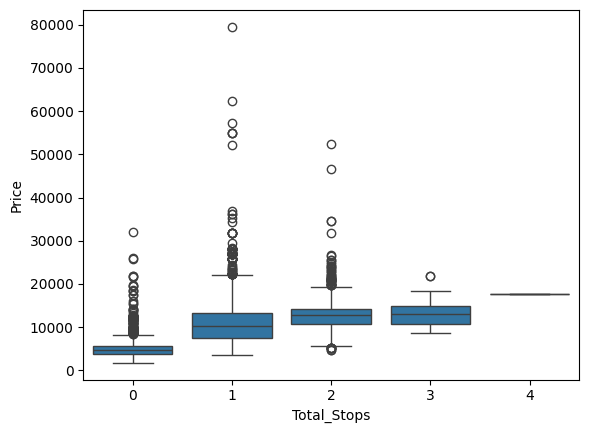

In [ ]:
sns.boxplot(x='Total_Stops', y='Price', data=dataset)

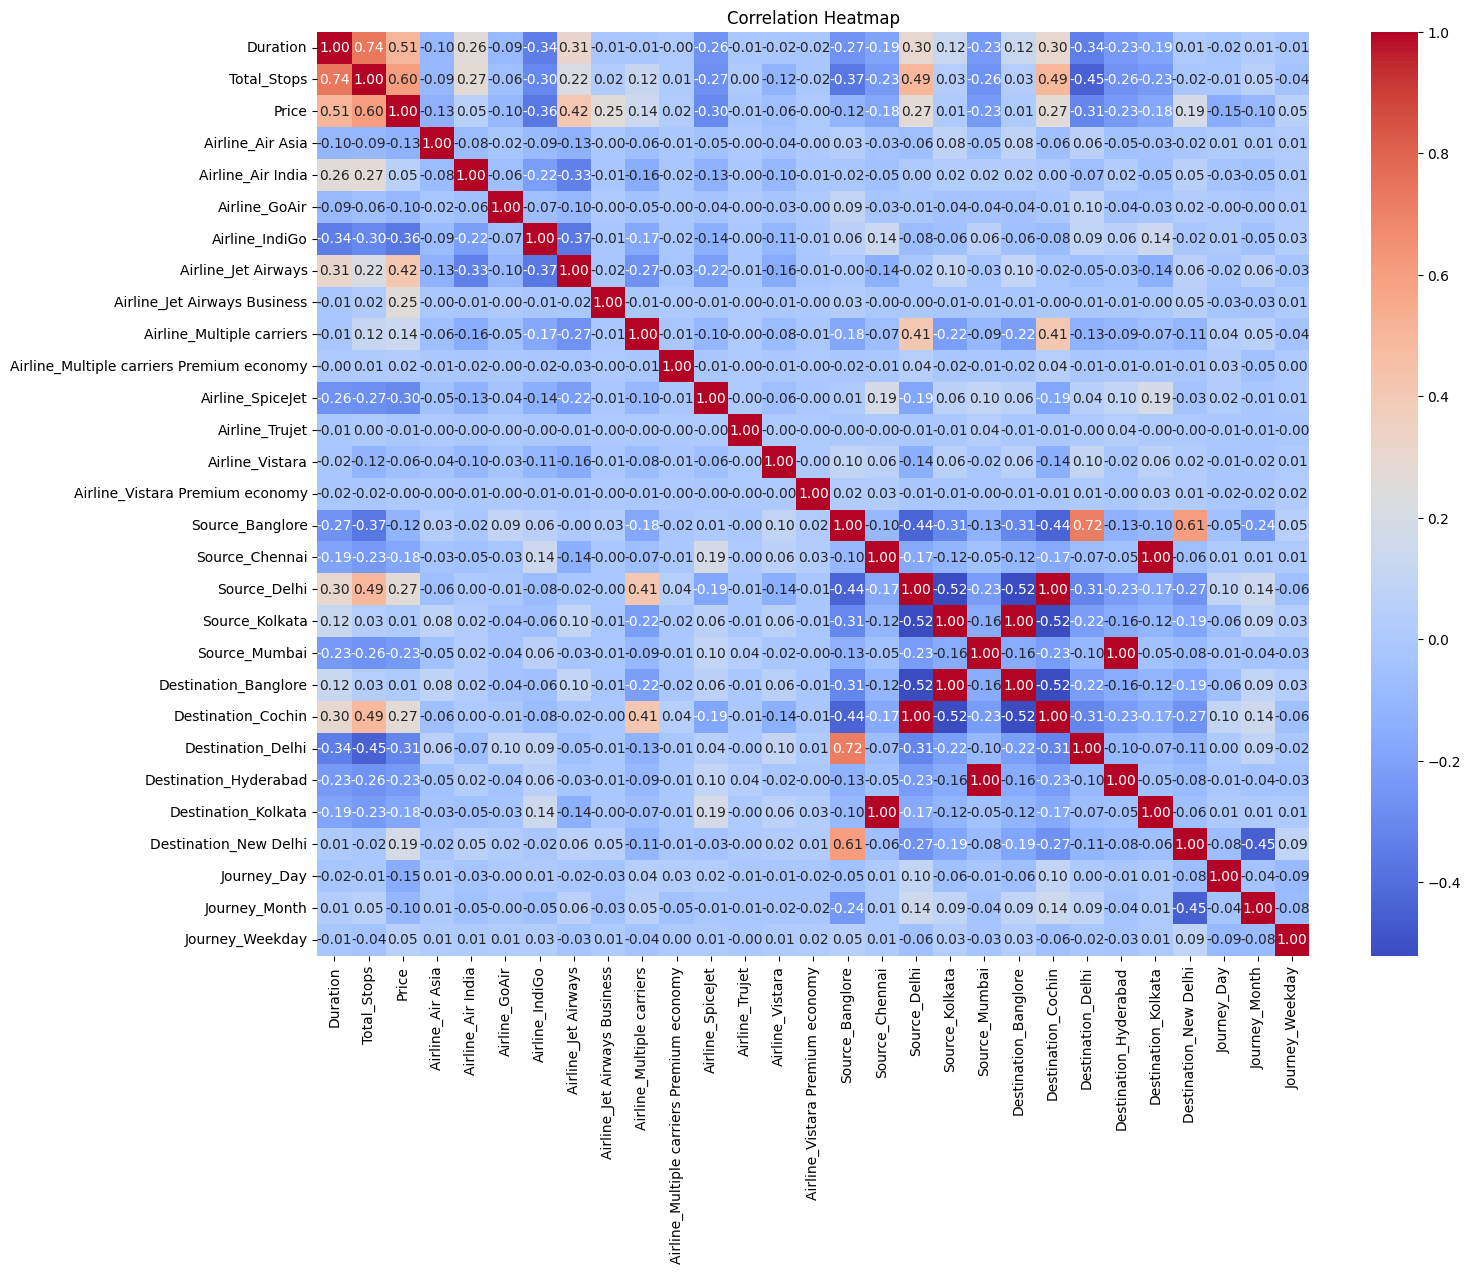

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Modelling

In [ ]:
# Setup

X = dataset.drop(columns=['Price'])
y = dataset['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest
rf_c = RandomForestClassifier(n_estimators=100, random_state=42)
rf_r = RandomForestRegressor(n_estimators=100, random_state=42)
rf_r.fit(X_train, y_train)

y_pred = rf_r.predict(X_test)

In [ ]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print(f'Root Mean Squared Error: {rf_rmse}')

rf_r2 = r2_score(y_test, y_pred)
print(f'R-squared: {rf_r2}')

Root Mean Squared Error: 2198.8019033676424
R-squared: 0.7715584216335669


In [ ]:
xgb_r = xg.XGBRegressor(objective = 'reg:squarederror',
                        eval_metric = 'rmse',
                        n_estimators = 100,
                        seed = 123)
xgb_r.fit(X_train, y_train)

y_pred = xgb_r.predict(X_test)

In [ ]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
print(f'Root Mean Squared Error: {xgb_rmse}')

xgb_r2 = r2_score(y_test, y_pred)
print(f'R-squared: {xgb_r2}')

Root Mean Squared Error: 1993.060272545715
R-squared: 0.8123088479042053
